In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, AveragePooling2D, Flatten, Dropout,Conv2D,UpSampling2D
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(tf.__version__)

2.4.1


In [2]:
brain_df = pd.read_csv('Dataset/Healthcare AI Datasets/Brain_MRI/data_mask.csv')

In [3]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
...,...,...,...,...
3924,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,0
3925,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,0
3926,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,0
3927,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,0


In [4]:
brain_df['image_path'][1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [5]:
brain_df['mask_path'][1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [6]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

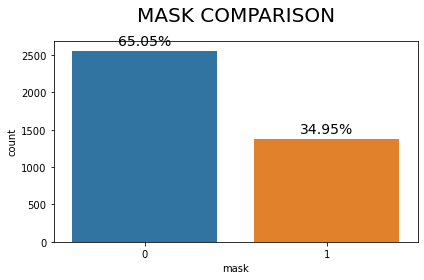

In [7]:
ax = sns.countplot(brain_df['mask'])

for val in ax.patches:
    pct = '{:.2f}%'.format(100*val.get_height()/brain_df.shape[0])
    xpos = val.get_x() + val.get_width() /2
    ypos = val.get_height()
    ax.annotate(pct,(xpos,ypos), ha='center', va='center', fontsize=14, xytext = (0,10), textcoords= 'offset points')
    
plt.title('MASK COMPARISON', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

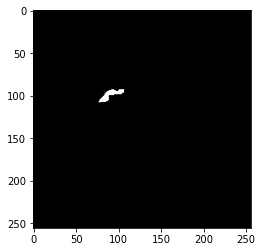

In [8]:
image = os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',brain_df['mask_path'][623])
plt.imshow(cv2.imread(image))

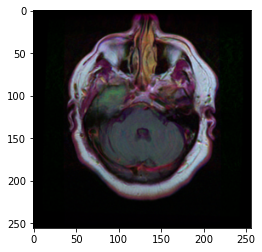

In [9]:
image = os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',brain_df['image_path'][623])
plt.imshow(cv2.imread(image))

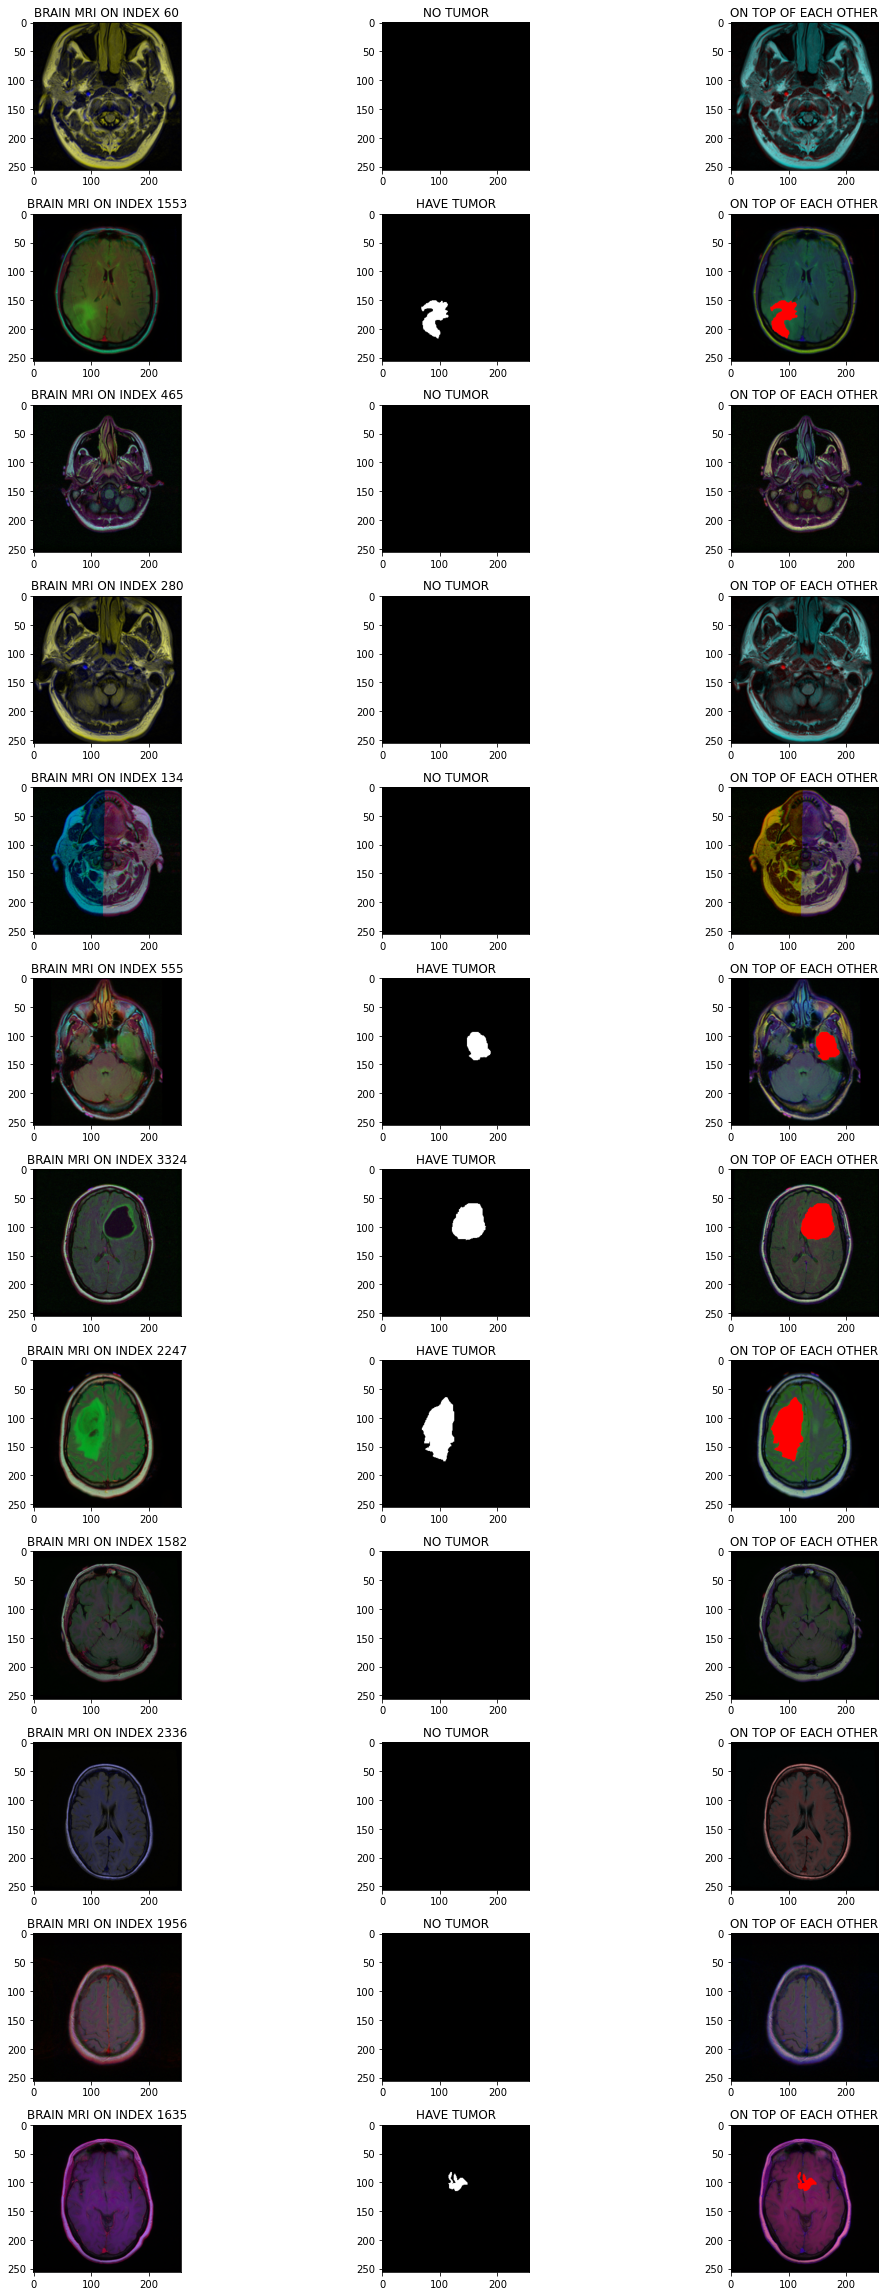

In [10]:
import random
from skimage import io
fig, axs = plt.subplots(12,3, figsize=(16,32))
count = 0
for x in range(12):
    i = random.randint(0,len(brain_df))
    axs[count][0].title.set_text('BRAIN MRI ON INDEX {}'.format(i))
    axs[count][0].imshow(cv2.imread(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',brain_df['image_path'][i])))
    axs[count][1].title.set_text('HAVE TUMOR' if '1' == str(brain_df['mask'][i]) else 'NO TUMOR')
    axs[count][1].imshow(cv2.imread(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',brain_df['mask_path'][i])))
    axs[count][2].title.set_text('ON TOP OF EACH OTHER')
    
    img = io.imread(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',brain_df['image_path'][i]))
    mask = io.imread(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',brain_df['mask_path'][i]))
    img[mask == 255] = (255,0,0)
    
    axs[count][2].imshow(img)
    count += 1
plt.tight_layout()

In [11]:
brain_df = brain_df.drop('patient_id',axis=1)

In [12]:
brain_df['mask'] = brain_df['mask'].apply(lambda x : str(x))

In [13]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df,test_size = 0.15)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.15)

In [16]:
train_generator = datagen.flow_from_dataframe(
                                            dataframe = train,
                                            directory = 'Dataset/Healthcare AI Datasets/Brain_MRI/',
                                            x_col = 'image_path',
                                            y_col = 'mask',
                                            batch_size= 16,
                                            class_mode = 'categorical',
                                            subset = 'training',
                                            shuffle = True,
                                            target_size = (256,256))

validation_generator = datagen.flow_from_dataframe(
                                            dataframe = train,
                                            directory = 'Dataset/Healthcare AI Datasets/Brain_MRI/',
                                            x_col = 'image_path',
                                            y_col = 'mask',
                                            batch_size= 16,
                                            class_mode = 'categorical',
                                            subset = 'validation',
                                            shuffle = True,
                                            target_size = (256,256))

test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
                                            dataframe = test,
                                            directory = 'Dataset/Healthcare AI Datasets/Brain_MRI/',
                                            x_col = 'image_path',
                                            y_col = 'mask',
                                            batch_size= 16,
                                            class_mode = 'categorical',
                                            shuffle = False,
                                            target_size = (256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [17]:
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256,256,3)))

In [18]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
for layers in basemodel.layers:
    layers.trainable = False

In [20]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(200, activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(256,activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam',metrics = ['accuracy'])

In [23]:
earlystopping = EarlyStopping(monitor ='val_loss', mode = 'min', verbose = 1, patience=20)

checkpointer = ModelCheckpoint(filepath = 'classifier-resnet_weights.hdf5', verbose = 1, save_best_only= True)

In [44]:
history = model.fit(train_generator,epochs=2, steps_per_epoch = train_generator.n//16, validation_data = validation_generator, validation_steps= validation_generator.n//16, callbacks = [checkpointer, earlystopping])

Epoch 1/2
177/177 [==============================] - 429s 2s/step - loss: 0.6384 - accuracy: 0.6383 - val_loss: 0.6366 - val_accuracy: 0.6673

Epoch 00001: val_loss did not improve from 0.61625
Epoch 2/2
177/177 [==============================] - 576s 3s/step - loss: 0.6519 - accuracy: 0.6468 - val_loss: 0.6353 - val_accuracy: 0.6714

Epoch 00002: val_loss did not improve from 0.61625


In [45]:
model_json = model.to_json()
with open("classifier-resnet-model.json",'w') as json_file:
    json_file.write(model_json)

In [24]:
with open('resnet-50-MRI.json','r') as json_file:
    json_saveModel = json_file.read()

model = tf.keras.models.model_from_json(json_saveModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categprical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
test_predict = model.predict(test_generator, steps = test_generator.n//16, verbose=1)

36/36 [==============================] - 79s 2s/step


In [26]:
test_predict.shape

(576, 2)

In [27]:
test_predict

array([[1.0000000e+00, 1.7357969e-10],
       [7.1059145e-07, 9.9999928e-01],
       [1.7375251e-11, 1.0000000e+00],
       ...,
       [1.0000000e+00, 1.7832623e-17],
       [9.9984276e-01, 1.5716327e-04],
       [1.8558335e-11, 1.0000000e+00]], dtype=float32)

In [28]:
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))
    
predict  = np.array(predict)

In [29]:
predict

array(['0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0',
       '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0',
       '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1',
       '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1',
       '1', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0',
       '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1',
       '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1',
       '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '1

In [30]:
original = np.asarray(test['mask'][:len(predict)])
len(original)

576

In [31]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9774305555555556

              precision    recall  f1-score   support

           0    0.97954   0.98711   0.98331       388
           1    0.97297   0.95745   0.96515       188

    accuracy                        0.97743       576
   macro avg    0.97626   0.97228   0.97423       576
weighted avg    0.97740   0.97743   0.97738       576



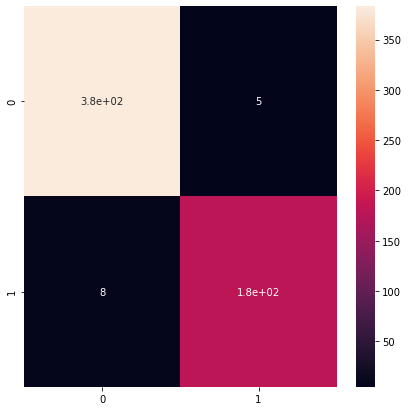

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(original, predict)
plt.figure(figsize=(7,7))
sns.heatmap(cm,annot=True)
print(classification_report(original, predict, digits=5))

In [33]:
brain_df_mask = brain_df[brain_df['mask'] == str(1)]
brain_df_mask.shape

(1373, 3)

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(brain_df_mask, test_size=0.15)
x_test, x_val = train_test_split(x_val, test_size=0.5)

In [35]:
train_x = list(x_train.image_path)
train_y = list(x_train.mask_path)

val_x = list(x_val.image_path)
val_y = list(x_val.mask_path)



In [36]:
train_ids = []
train_mask = []
val_ids = []
val_mask = []
for ids in train_x:
    train_ids.append(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',ids))
for mask in train_y:
    train_mask.append(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',mask))
for ids in val_x:
    val_ids.append(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',ids))
for mask in val_y:
    val_mask.append(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',mask))

In [37]:
from utilities import DataGenerator

training_generator = DataGenerator(train_ids,train_mask)
val_generator = DataGenerator(val_ids,val_mask)

In [38]:
def resblock(X,f):
    
    #Make a copy first
    X_copy = X
    
    #Main Path
    X = Conv2D(f, kernel_size=(1,1), strides=(1,1),kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3),strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    #Short Path
    X_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    #Adding the output from main path and short path together
    X = Add()([X,X_copy])
    X = Activation('relu')(X)
    
    return X

In [39]:
def upsampling(x, skip):
    x = UpSampling2D()(x)
    merge = Concatenate()([x,skip])
    
    return merge

In [40]:
input_shape = (256,256,3)

X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation='relu', padding='same', kernel_initializer = 'he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPooling2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPooling2D(pool_size=(2,2))(conv4_in)

#Stage 5 (Bottleneck)
conv5_in = resblock(pool_4, 256)

#Upsampling stage 1
up_1 = upsampling(conv5_in,conv4_in)
up_1 = resblock(up_1, 128)

#Upsampling stage 2
up_2 = upsampling(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upsampling stage 3
up_3 = upsampling(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upsampling stage 4
up_4 = upsampling(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
Output = Conv2D(1,(1,1), padding='same', activation='sigmoid')(up_4)

model_seg = Model(inputs = X_input, outputs = Output)

In [41]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

In [42]:
from utilities import tversky, focal_tversky, tversky_loss

In [43]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics = [tversky])

In [44]:
earlystopping = EarlyStopping(monitor ='val_loss', mode='min', verbose=1, patience=20)

checkpointer = ModelCheckpoint(filepath = 'ResUnet-weights.hdf5', verbose=1, save_best_only=True)

In [69]:
history = model_seg.fit(training_generator, validation_data = val_generator, epochs = 20, callbacks = [earlystopping, checkpointer])

Epoch 1/20
72/72 [==============================] - 917s 13s/step - loss: 0.4078 - tversky: 0.6950 - val_loss: 0.5896 - val_tversky: 0.5053

Epoch 00001: val_loss improved from 0.62002 to 0.58961, saving model to ResUnet-weights.hdf5
Epoch 2/20
72/72 [==============================] - 881s 12s/step - loss: 0.3610 - tversky: 0.7404 - val_loss: 0.4703 - val_tversky: 0.6323

Epoch 00002: val_loss improved from 0.58961 to 0.47033, saving model to ResUnet-weights.hdf5
Epoch 3/20
72/72 [==============================] - 905s 13s/step - loss: 0.3312 - tversky: 0.7688 - val_loss: 0.3571 - val_tversky: 0.7455

Epoch 00003: val_loss improved from 0.47033 to 0.35705, saving model to ResUnet-weights.hdf5
Epoch 4/20
72/72 [==============================] - 898s 12s/step - loss: 0.3025 - tversky: 0.7956 - val_loss: 0.4346 - val_tversky: 0.6688

Epoch 00004: val_loss did not improve from 0.35705
Epoch 5/20
72/72 [==============================] - 882s 12s/step - loss: 0.2852 - tversky: 0.8113 - val_l

In [36]:
model_json = model_seg.to_json()
with open('ResUnet-model.json','w') as json_file:
    json_file.write(model_json)

In [45]:
from utilities import tversky, focal_tversky, tversky_loss

with open('ResUNet-MRI.json','r') as json_file:
    json_saveModel = json_file.read()

model_seg = tf.keras.models.model_from_json(json_saveModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss= focal_tversky, metrics = [tversky])

In [46]:
def prediction(test, model, model_seg):
    
    directory = 'Dataset/Healthcare AI Datasets/Brain_MRI/'
    
    mask = []
    image_id = []
    has_mask = []
    
    for i in test.image_path:
        path = directory + str(i)
        
        img = io.imread(path)
        
        img = img * 1./255.
        
        img = cv2.resize(img,(256,256))
        
        img = np.array(img, dtype = np.float64)
        
        img = np.reshape(img, (1,256,256,3))
        
        is_detect = model.predict(img)
        
        if np.argmax(is_detect) == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
            continue
        
        img = io.imread(path)
        
        X = np.empty((1,256,256,3))
        
        img = cv2.resize(img,(256,256))
        img = np.array(img, dtype = np.float64)
        
        img -= img.mean()
        img /= img.std()
        
        X[0,] = img
        
        prediction = model_seg.predict(X)
        
        if prediction.round().astype(int).sum() == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
        else:
            image_id.append(i)
            has_mask.append(1)
            mask.append(prediction)
            
    return image_id, mask, has_mask

In [47]:
test

,image_path,mask_path,mask
3177,TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_34...,TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_34...,0
2651,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26...,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26...,1
2154,TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20...,TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20...,1
2072,TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19...,TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19...,0
3535,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44...,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44...,1
...,...,...,...
379,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_4.tif,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_4_...,0
581,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_6.tif,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_6_...,0
1658,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_16...,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_16...,1
3389,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_38...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_38...,1


In [48]:
# from utilities import prediction

image_id, mask, has_mask = prediction(test, model, model_seg)

In [49]:
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_34...,No mask,0
1,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26...,"[[[[7.3735293e-07], [4.400444e-06], [5.178092e...",1
2,TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20...,"[[[[3.2859948e-06], [6.5539293e-06], [1.666366...",1
3,TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19...,No mask,0
4,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44...,"[[[[5.713705e-07], [2.0212576e-06], [4.087584e...",1
...,...,...,...
585,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_4.tif,No mask,0
586,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_6.tif,No mask,0
587,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_16...,"[[[[8.710391e-07], [4.085187e-06], [9.7359225e...",1
588,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_38...,"[[[[8.7904533e-07], [4.2822926e-06], [1.282557...",1


In [50]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_34...,TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_34...,0,No mask,0
1,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26...,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26...,1,"[[[[7.3735293e-07], [4.400444e-06], [5.178092e...",1
2,TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20...,TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_20...,1,"[[[[3.2859948e-06], [6.5539293e-06], [1.666366...",1
3,TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19...,TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19...,0,No mask,0
4,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44...,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44...,1,"[[[[5.713705e-07], [2.0212576e-06], [4.087584e...",1
...,...,...,...,...,...
585,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_4.tif,TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_4_...,0,No mask,0
586,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_6.tif,TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_6_...,0,No mask,0
587,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_16...,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_16...,1,"[[[[8.710391e-07], [4.085187e-06], [9.7359225e...",1
588,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_38...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_38...,1,"[[[[8.7904533e-07], [4.2822926e-06], [1.282557...",1


In [51]:
count = 0

fig, ax = plt.subplots(10,5, figsize=(30,50))

for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 10:
        img = io.imread(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',df_pred['image_path'][i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[count][0].title.set_text('BRAIN MRI')
        ax[count][0].imshow(img)
        
        mask = io.imread(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',df_pred['mask_path'][i]))
        ax[count][1].title.set_text('Original Mask')
        ax[count][1].imshow(mask)
        
        predicted_mask = np.asarray(df_pred['predicted_mask'][i])[0].squeeze().round())
        ax[count][2].title.set_text('AI Predicted Mask')
        ax[count][2].imshow(predicted_mask)
        
        img[mask == 255] = (255,0,0)
        ax[count][3].title.set_text('MRI with Original Mask')
        ax[count][3].imshow(img)
        
        img = io.imread(os.path.join('Dataset/Healthcare AI Datasets/Brain_MRI/',df_pred['image_path'][i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img[predicted_mask == 1] = (255,0,0)
        ax[count][4].title.set_text('MRI with AI Predicted Mask')
        ax[count][4].imshow(img)
        count += 1
        
fig.tight_layout()

SyntaxError: invalid syntax (<ipython-input-51-4ec719d4ab68>, line 17)